[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/main/notebooks/herculens__Starting_guide.ipynb)

# Starting guide for a general use of `Herculens`

This notebooks show a basic example of simulating and modeling the image of a galaxy-galaxy strong lens system using the fully differentiable capabilities of `Herculens`.

What is included:
- Simulation of an HST-like observation of a strong lens
- Full modeling of the simulated data with smooth profiles
- Estimation of parameter covariances via the Fisher information matrix (FIM)
- Variation inference to analytically model the joint posterior distribution (SVI with `numpyro`)
- Posterior sampling via Hamiltonian Monte Carlo (HMC with `blackjax`)


__authors__: @aymgal, @austinpeel

__last update__: 04/04/23

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git
    !pip install --quiet git+https://github.com/aymgal/utax.git
    !pip install --quiet optax blackjax-nightly numpyro
    !pip install --quiet arviz corner

In [2]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
import numpy as np
from copy import deepcopy
import time
from functools import partial
import corner
from pprint import pprint
import pickle as pkl

# JAX
import jax
jax.config.update("jax_enable_x64", True)  # comment for single precision
import jax.numpy as jnp
if IN_COLAB:
    _ = jnp.zeros(10)  # allocate the GPU memory
    #os.environ['JAX_JIT_PJIT_API_MERGE'] = '0'  # temporary fix bug with latest JAX version (https://github.com/pyro-ppl/numpyro/issues/1542)

# NUTS Hamiltonian MC sampling
import blackjax

# probabilistic model
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints

# variational inference
import optax  # optimizers
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal, AutoBNAFNormal

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.Inference.loss import Loss
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.jaxopt import JaxoptOptimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

/Users/aymgal/miniconda3/envs/herculens39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
SAVE_SAMPLES_TO_DISK = False
LOAD_SAMPLES_FROM_DISK = False  # ATTENTION: if True, will overwrite the samples by the ones from the pickled file

## Simulate an observation of a strong lens

### Define the coordinates grid

In [4]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Setup point spread function (PSF) and observation/noise properties

For simplicity we assume a Gaussian PSF but you can also provide an image of the PSF via `psf_type='PIXELATED'`.

In [5]:
psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pix_scl)

noise = Noise(npix, npix, background_rms=1e-2, exposure_time=1000.)

### Lens galaxy

We assume a SIE embedded in an external shear

In [6]:
# Lens mass
lens_mass_model_input = MassModel(['SIE', 'SHEAR'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
print(e1, e2)
print(gamma1, gamma2)
kwargs_lens_input = [
    {'theta_E': 1.5, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)


# Lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

# Source light
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.1}
]


0.13732309941975984 0.03937676511671417
-0.00927050983124842 0.02853169548885461


### Generate the lens image

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_mass_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
key_sim = jax.random.PRNGKey(291837)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_sim)

In [8]:
# Plotting engine
plotter = Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

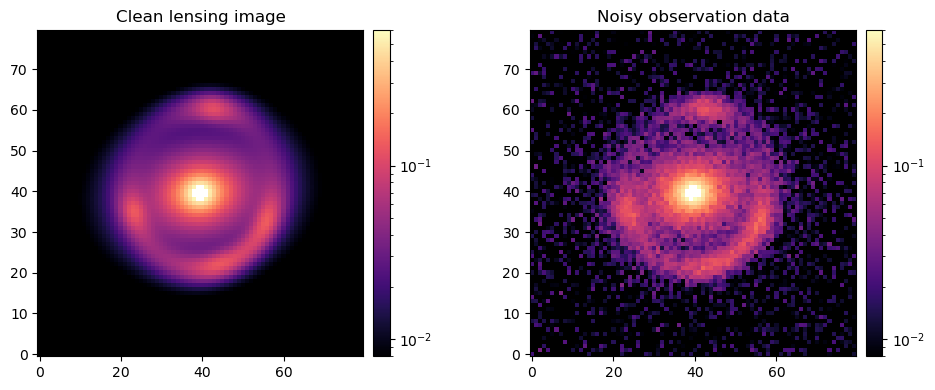

In [9]:
# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

## Fit the image and find best-fit parameters

In [10]:
kwargs_numerics_fit = {'supersampling_factor': 2}
lens_image = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model_input),
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_fit)

### Decide on the parameters to optimize

In [11]:
class ProbModel(NumpyroModel):
    
    def model(self):
        # Parameters of the source
        prior_source = [
          {
              'amp': numpyro.sample('source_amp', dist.LogNormal(1.0, 0.1)),
         'R_sersic': numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.2, 0.1, low=0.05)), 
         'n_sersic': numpyro.sample('source_n', dist.Uniform(1., 3.)), 
         'e1': numpyro.sample('source_e1', dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('source_e2', dist.TruncatedNormal(0.0, 0.05, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('source_center_x', dist.Normal(0.05, 0.02)), 
        'center_y': numpyro.sample('source_center_y', dist.Normal(0.1, 0.02))}
        ]

        # Parameters of the lens
        cx = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
        cy = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))

        # Parameters of the lens light, with center relative the lens mass
        prior_lens_light = [
        {'amp': numpyro.sample('light_amp', dist.LogNormal(2., 0.1)), 
         'R_sersic': numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.1)), 
         'n_sersic': numpyro.sample('light_n', dist.Uniform(2., 5.)), 
         'e1': numpyro.sample('light_e1', dist.TruncatedNormal(0.1, 0.05, low=-0.3, high=0.3)),
         'e2': numpyro.sample('light_e2', dist.TruncatedNormal(0.04, 0.05, low=-0.3, high=0.3)),
         'center_x': cx, 
         'center_y': cy}
        ]

        prior_lens = [
        # power-law
        {
            'theta_E': numpyro.sample('lens_theta_E', dist.Normal(1.5, 0.1)),
         'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)),
         'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)),
         'center_x': numpyro.sample('lens_center_x', dist.Normal(cx, 0.005)), 
         'center_y': numpyro.sample('lens_center_y', dist.Normal(cy, 0.005))},
        # external shear, with fixed origin
        {'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)), 
         'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(0., 0.1, low=-0.3, high=0.3)), 
         'ra_0': 0.0, 'dec_0': 0.0}
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_var = noise.C_D_model(model_image)
        model_std = jnp.sqrt(model_var)
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
    
    def params2kwargs(self, params):
        # functions that takes the flattended dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2'],
        'center_x': params['lens_center_x'],
        'center_y': params['lens_center_y']},
        {'gamma1': params['lens_gamma1'],
        'gamma2': params['lens_gamma2'],
        'ra_0': 0.0,
        'dec_0': 0.0}],
        'kwargs_source': [{'amp': params['source_amp'],
        'R_sersic': params['source_R_sersic'],
        'n_sersic': params['source_n'],
        'e1': params['source_e1'],
        'e2': params['source_e2'],
        'center_x': params['source_center_x'],
        'center_y': params['source_center_y']}],
        'kwargs_lens_light': [{'amp': params['light_amp'],
        'R_sersic': params['light_R_sersic'],
        'n_sersic': params['light_n'],
        'e1': params['light_e1'],
        'e2': params['light_e2'],
        'center_x': params['light_center_x'],
        'center_y': params['light_center_y']}]}
        return kw

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 21


In [12]:
# visualize the probabilistic graph thanks to NumPyro utility
#prob_model.render_model()

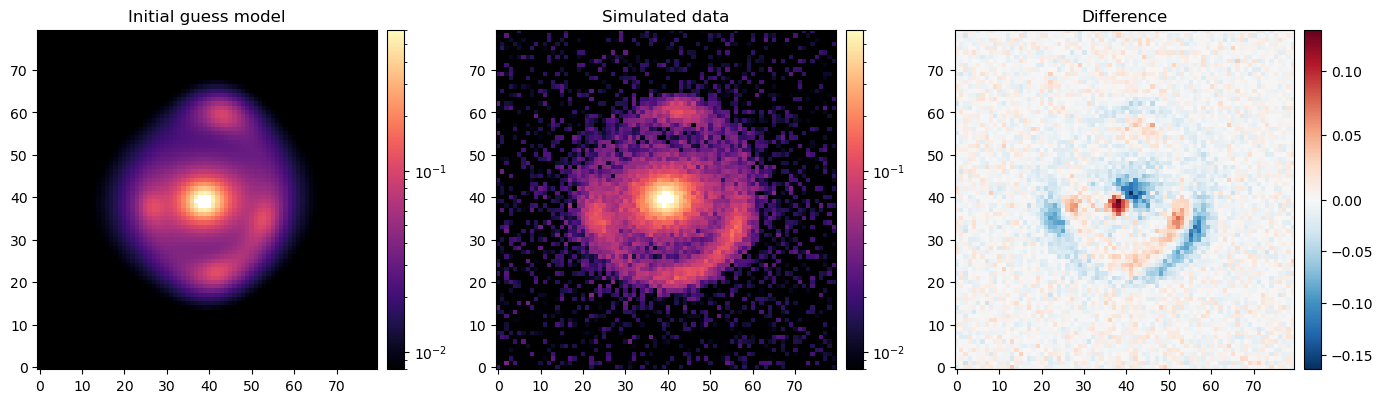

In [13]:
# visualize initial guess
init_params = prob_model.get_sample(seed=212)  # constrained space
init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space
kwargs_init = prob_model.params2kwargs(init_params)  # constrained space
initial_model = lens_image.model(**kwargs_init)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Define the loss function

This class is essentially calling the `log_prob` of the probabilistic model defined above, but adds a simple interface to get the gradient and hessian of the loss function.

In [14]:
loss = Loss(prob_model)
print("Initial loss =", loss(init_params_unconst))
#print("Initial gradient =", loss.gradient(init_params_unconst))

Initial loss = -16928.643728849125


### Set the optimizer to minimize the loss function

In [15]:
optimizer = JaxoptOptimizer(loss, loss_norm_optim=data.size)  # loss_norm_optim is to reduce loss magnitude
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer.run_scipy(init_params_unconst, method='BFGS', maxiter=600)
print("Runtime:", runtime)

Runtime: 2.9787399768829346


Final loss = -19973.291751068922


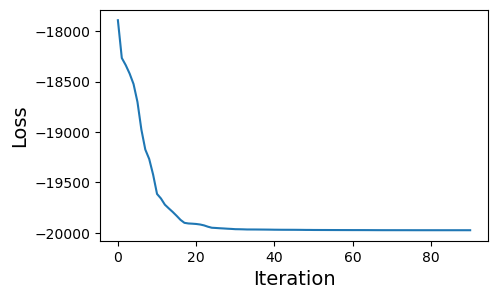

In [16]:
print("Final loss =", loss(best_fit))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
plt.show()

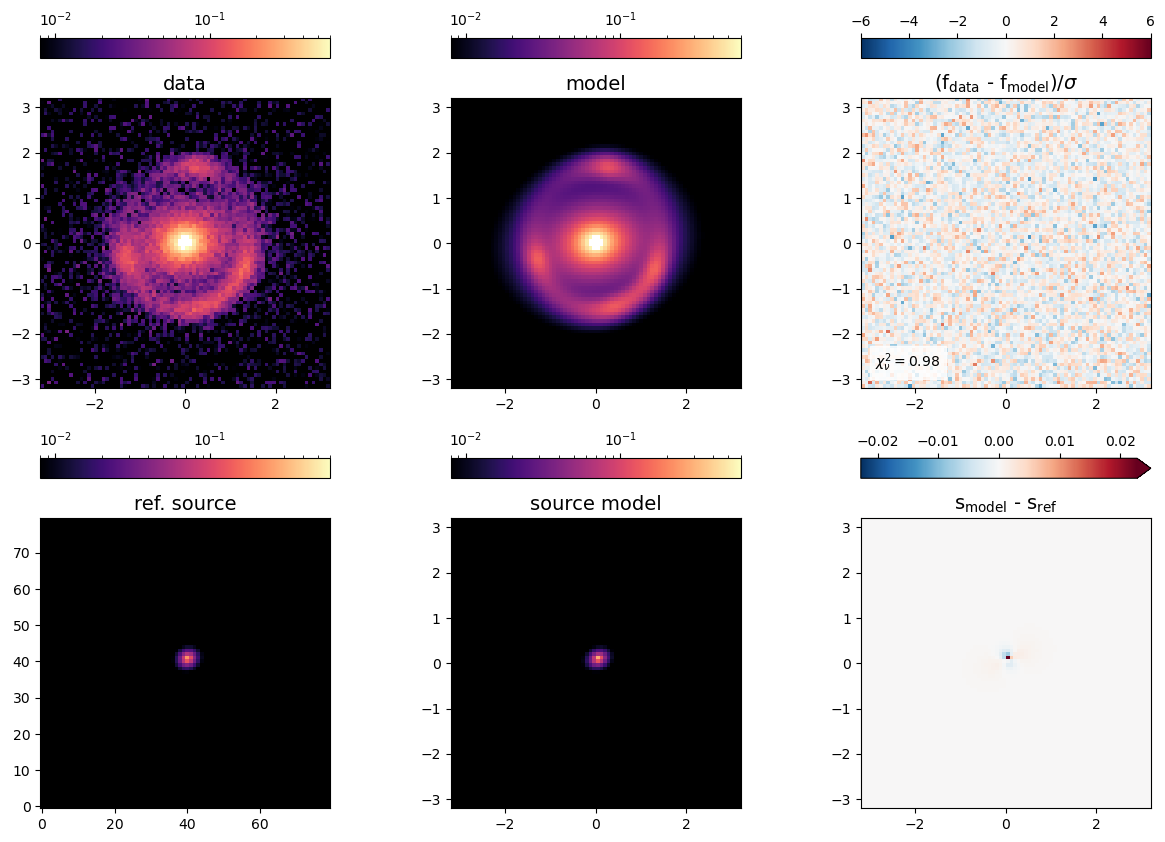

In [17]:
# the best-fit values are in unconstrained space so we transform them here
kwargs_best_fit = prob_model.params2kwargs(prob_model.constrain(best_fit))

fig = plotter.model_summary(lens_image, kwargs_best_fit, show_source=True)
plt.show()

In [18]:
# print resulting parameters
print("BEST-FIT VALUES:")
pprint(kwargs_best_fit)

print("="*80)

# compare to input values
print("INPUT VALUES:")
pprint(kwargs_all_input)

BEST-FIT VALUES:
{'kwargs_lens': [{'center_x': Array(0.00333478, dtype=float64),
                  'center_y': Array(0.00704154, dtype=float64),
                  'e1': Array(0.09699873, dtype=float64),
                  'e2': Array(0.02698653, dtype=float64),
                  'theta_E': Array(1.48995531, dtype=float64)},
                 {'dec_0': 0.0,
                  'gamma1': Array(-0.02891141, dtype=float64),
                  'gamma2': Array(0.02015268, dtype=float64),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': Array(0.97029312, dtype=float64),
                        'amp': Array(8.32179464, dtype=float64),
                        'center_x': Array(-0.00101365, dtype=float64),
                        'center_y': Array(0.00367673, dtype=float64),
                        'e1': Array(0.13758445, dtype=float64),
                        'e2': Array(0.03992822, dtype=float64),
                        'n_sersic': Array(2.95171963, dtype=float64)}],
 'kwargs_

## Stochastic variational inference (SVI)

Using `numpyro` SVI implementation

In [19]:
# create the guide automatically, i.e. the surrogate posterior model
from numpyro.infer import init_to_median #, init_to_values

# We use a guide that relates to the Mean-Field approximation (normal posterior)
guide = AutoNormal(prob_model.model, 
                   init_loc_fn=init_to_median,
                   init_scale=1e-6)
#guide = AutoBNAFNormal(prob_model.model)  # normalization flow

#guide._init_locs = best_fit  # not good programming practice

# setup and initialize the optimizer
# here we use the same scheduling than in Gu et al. 2022
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                        power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
optimizer_vi = numpyro.optim.optax_to_numpyro(opt)

svi = SVI(prob_model.model, guide, optimizer_vi, Trace_ELBO(num_particles=100))

In [20]:
num_iter_svi = 4_000

start = time.time()
svi_result = svi.run(jax.random.PRNGKey(0), num_iter_svi, stable_update=True, progress_bar=True)
print("SVI runtime:", time.time()-start)

100%|██████████| 4000/4000 [10:33<00:00,  6.31it/s, init loss: -15231.4805, avg. loss [3801-4000]: -19887.6912]


SVI runtime: 636.4393649101257


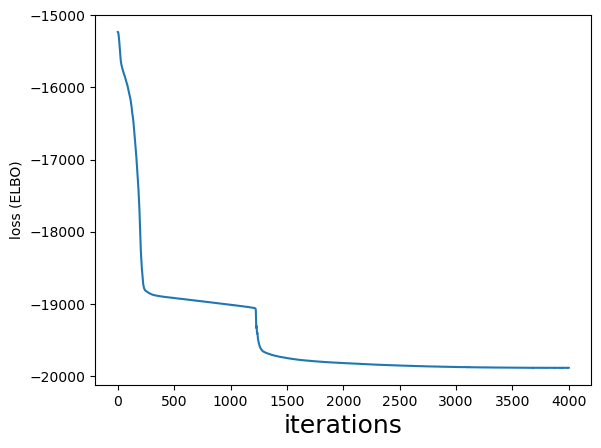

In [21]:
# check convergence of ELBO loss
plt.plot(svi_result.losses)
plt.xlabel("iterations", fontsize=18)
plt.ylabel("loss (ELBO)")
plt.show()

In [22]:
# retrieve samples from the guide posteriors (still in unconstrained space!)
svi_samples = guide.sample_posterior(
    jax.random.PRNGKey(0), svi_result.params, 
    sample_shape=(3000,)
)

# for comparison we also retrieve samples from the prior (i.e. before VI)
prior_samples = Predictive(prob_model.model, num_samples=3000)(jax.random.PRNGKey(0))
del prior_samples['obs']

In [23]:
# create the input vector for reference
input_params = {
    'lens_theta_E': kwargs_all_input['kwargs_lens'][0]['theta_E'],
    'lens_e1': kwargs_all_input['kwargs_lens'][0]['e1'],
    'lens_e2': kwargs_all_input['kwargs_lens'][0]['e2'],
    'lens_center_x': kwargs_all_input['kwargs_lens'][0]['center_x'],
    'lens_center_y': kwargs_all_input['kwargs_lens'][0]['center_y'],
    'lens_gamma1': kwargs_all_input['kwargs_lens'][1]['gamma1'],
    'lens_gamma2': kwargs_all_input['kwargs_lens'][1]['gamma2'],
    'light_amp': kwargs_all_input['kwargs_lens_light'][0]['amp'],
    'light_R_sersic': kwargs_all_input['kwargs_lens_light'][0]['R_sersic'],
    'light_n': kwargs_all_input['kwargs_lens_light'][0]['n_sersic'],
    'light_e1': kwargs_all_input['kwargs_lens_light'][0]['e1'],
    'light_e2': kwargs_all_input['kwargs_lens_light'][0]['e2'],
    'light_center_x': kwargs_all_input['kwargs_lens_light'][0]['center_x'],
    'light_center_y': kwargs_all_input['kwargs_lens_light'][0]['center_y'],
    'source_amp': kwargs_all_input['kwargs_source'][0]['amp'],
    'source_R_sersic': kwargs_all_input['kwargs_source'][0]['R_sersic'],
    'source_n': kwargs_all_input['kwargs_source'][0]['n_sersic'],
    'source_e1': kwargs_all_input['kwargs_source'][0]['e1'],
    'source_e2': kwargs_all_input['kwargs_source'][0]['e2'],
    'source_center_x': kwargs_all_input['kwargs_source'][0]['center_x'],
    'source_center_y': kwargs_all_input['kwargs_source'][0]['center_y'],
}

In [24]:
e1, e2, gamma1, gamma2

(Array(0.1373231, dtype=float64, weak_type=True),
 Array(0.03937677, dtype=float64, weak_type=True),
 Array(-0.00927051, dtype=float64, weak_type=True),
 Array(0.0285317, dtype=float64, weak_type=True))

In [25]:
input_params

{'lens_theta_E': 1.5,
 'lens_e1': Array(0.1373231, dtype=float64, weak_type=True),
 'lens_e2': Array(0.03937677, dtype=float64, weak_type=True),
 'lens_center_x': 0.0,
 'lens_center_y': 0.0,
 'lens_gamma1': Array(-0.00927051, dtype=float64, weak_type=True),
 'lens_gamma2': Array(0.0285317, dtype=float64, weak_type=True),
 'light_amp': 8.0,
 'light_R_sersic': 1.0,
 'light_n': 3.0,
 'light_e1': Array(0.1373231, dtype=float64, weak_type=True),
 'light_e2': Array(0.03937677, dtype=float64, weak_type=True),
 'light_center_x': 0.0,
 'light_center_y': 0.0,
 'source_amp': 4.0,
 'source_R_sersic': 0.2,
 'source_n': 2.0,
 'source_e1': 0.05,
 'source_e2': 0.05,
 'source_center_x': 0.05,
 'source_center_y': 0.1}

## Parameter covariance matrix from the Fisher information

Since we can compute the Hessian matrix analytically, we can use its evaluation at the MAP to obtain an estimation of the Fisher information matrix (FIM). Then we simply invert it to get a 1st order estimation of the covariance matrix associated with this MAP parameter values.

In [26]:
@jax.jit
def loss_constrained(params_const):
    params_unconst = prob_model.unconstrain(params_const)
    return loss(params_unconst)

@jax.jit
def hessian_constrained(params_const):
    return jax.jacfwd(jax.jacrev(loss_constrained))(params_const)

fisher_matrix = hessian_constrained(prob_model.constrain(best_fit))  # pytree
fisher_matrix, _ = jax.flatten_util.ravel_pytree(fisher_matrix)  # get the array
fisher_matrix = fisher_matrix.reshape((21, 21))  # reshape as a matrix
cov_matrix = jnp.linalg.inv(fisher_matrix) # invert to get covariance matrix

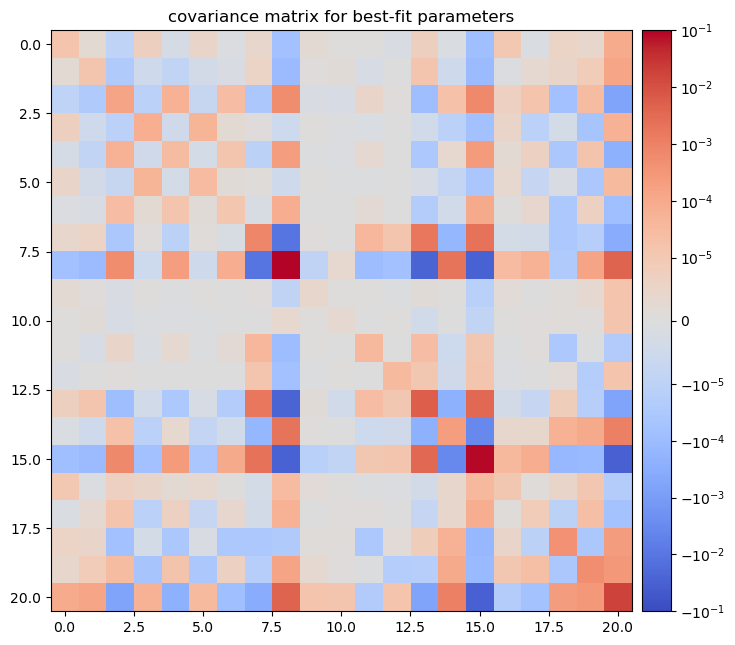

In [27]:
plt.figure(figsize=(8, 8))
plt.title("covariance matrix for best-fit parameters")
im = plt.imshow(cov_matrix, origin='upper', cmap='coolwarm', 
                norm=SymLogNorm(linthresh=1e-5, linscale=1, vmin=-1e-1, vmax=1e-1))
plot_util.nice_colorbar(im)
plt.show()

In [28]:
mean, unravel_fn = jax.flatten_util.ravel_pytree(prob_model.constrain(best_fit))
cov = cov_matrix
fim_samples = jax.vmap(unravel_fn)(np.random.multivariate_normal(mean, cov, size=5000))
#print(fim_samples)

## Posterior sampling with HMC

Using `backjax` with window adaptation strategy to tune the HMC parameters

In [29]:
@jax.jit
def logdensity_fn(args):
    return -loss(args)

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.8, 
    is_mass_matrix_diagonal=True,
    initial_step_size=1.0,
    progress_bar=True, 
)

num_steps_adaptation = 800

start = time.time()
(last_state, adapted_settings), info = adapt.run(jax.random.PRNGKey(0), best_fit, 
                                                 num_steps=num_steps_adaptation)
print("Time taken by HMC (blackjax) warmup phase:", time.time()-start)

print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})

Running window adaptation



Time taken by HMC (blackjax) warmup phase: 602.1378591060638
Warmup state (lens only, unconstrained) {'lens_center_x': Array(0.0091392, dtype=float64), 'lens_center_y': Array(0.01111096, dtype=float64), 'lens_e1': Array(0.63143264, dtype=float64), 'lens_e2': Array(0.23984672, dtype=float64), 'lens_gamma1': Array(-0.20981341, dtype=float64), 'lens_gamma2': Array(0.18707553, dtype=float64), 'lens_theta_E': Array(1.49109012, dtype=float64)}


In [30]:
best_fit.keys()

dict_keys(['lens_center_x', 'lens_center_y', 'lens_e1', 'lens_e2', 'lens_gamma1', 'lens_gamma2', 'lens_theta_E', 'light_R_sersic', 'light_amp', 'light_center_x', 'light_center_y', 'light_e1', 'light_e2', 'light_n', 'source_R_sersic', 'source_amp', 'source_center_x', 'source_center_y', 'source_e1', 'source_e2', 'source_n'])

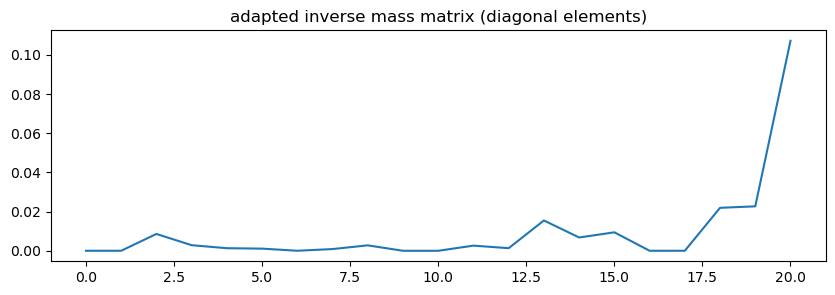

In [31]:
# visualize the inverse mass matrix we will use for HMC

plt.figure(figsize=(10, 3))
plt.title("adapted inverse mass matrix (diagonal elements)")
plt.plot(adapted_settings['inverse_mass_matrix'])
plt.show()

In [32]:
# setup the NUTS kernel with adapted settings
kernel = blackjax.nuts(logdensity_fn, **adapted_settings).step

# define the inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):

    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

num_steps_nuts = 1500

start = time.time()
states, infos = inference_loop(jax.random.PRNGKey(1), kernel, last_state, num_steps_nuts)
_ = states.position['lens_theta_E'].block_until_ready()
print("Time taken by HMC (blackjax) main phase:", time.time()-start)   

Time taken by HMC (blackjax) main phase: 467.7482979297638


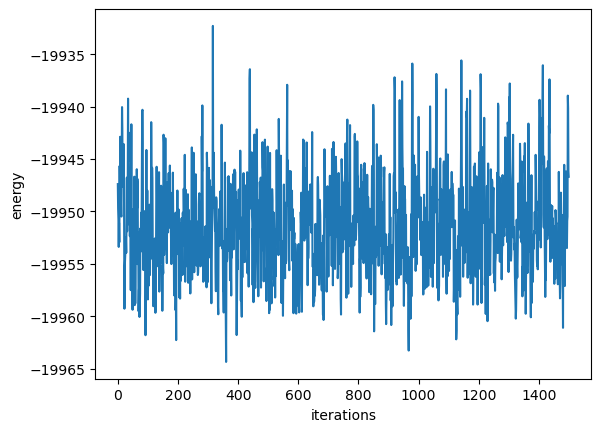

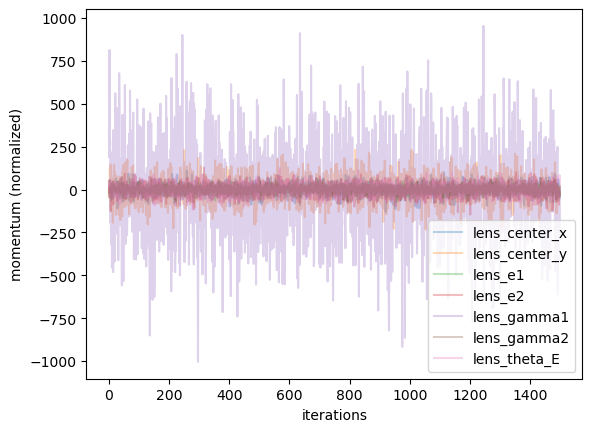

In [33]:
plt.figure()
plt.plot(infos.energy)
plt.xlabel("iterations")
plt.ylabel("energy")
plt.show()

plt.figure()
for k, v in infos.momentum.items():
    if 'lens' in k:
        plt.plot((v - np.median(v)) / np.median(v), label=k, alpha=0.3)
plt.legend()
plt.xlabel("iterations")
plt.ylabel("momentum (normalized)")
plt.show()

In [34]:
acceptance_rate = np.mean(infos.acceptance_rate)
num_divergent = np.mean(infos.is_divergent)

print(f"Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

Average acceptance rate: 0.84
There were 0.00% divergent transitions


In [35]:
# retrieve the HMC posterior samples
hmc_samples = jax.vmap(prob_model.constrain)(states.position)

## Compare posterior distributions

- obtained from the FIM
- via SVI
- via HMC (NUTS)

In [36]:
# save the chain to avoid re-running the notebook 
if SAVE_SAMPLES_TO_DISK:
    with open(os.path.join('output', 'starting_guide_samples_all.pkl'), 'wb') as f:
        samples_to_disk = {
            'prior_samples': prior_samples,
            'fim_samples': fim_samples,
            'svi_samples': svi_samples,
            'hmc_samples': hmc_samples,
            'input_params': input_params,
        }
        pkl.dump(samples_to_disk, f)
        print("WARNING: samples were saved to disk.")

if LOAD_SAMPLES_FROM_DISK:
    with open(os.path.join('output', 'starting_guide_samples_all.pkl'), 'rb') as f:
        samples_from_disk = pkl.load(f)
        prior_samples = samples_from_disk['prior_samples']
        fim_samples = samples_from_disk['fim_samples']
        svi_samples = samples_from_disk['svi_samples']
        hmc_samples = samples_from_disk['hmc_samples']
        input_params = samples_from_disk['input_params']
    print("WARNING: samples were loaded from disk.")

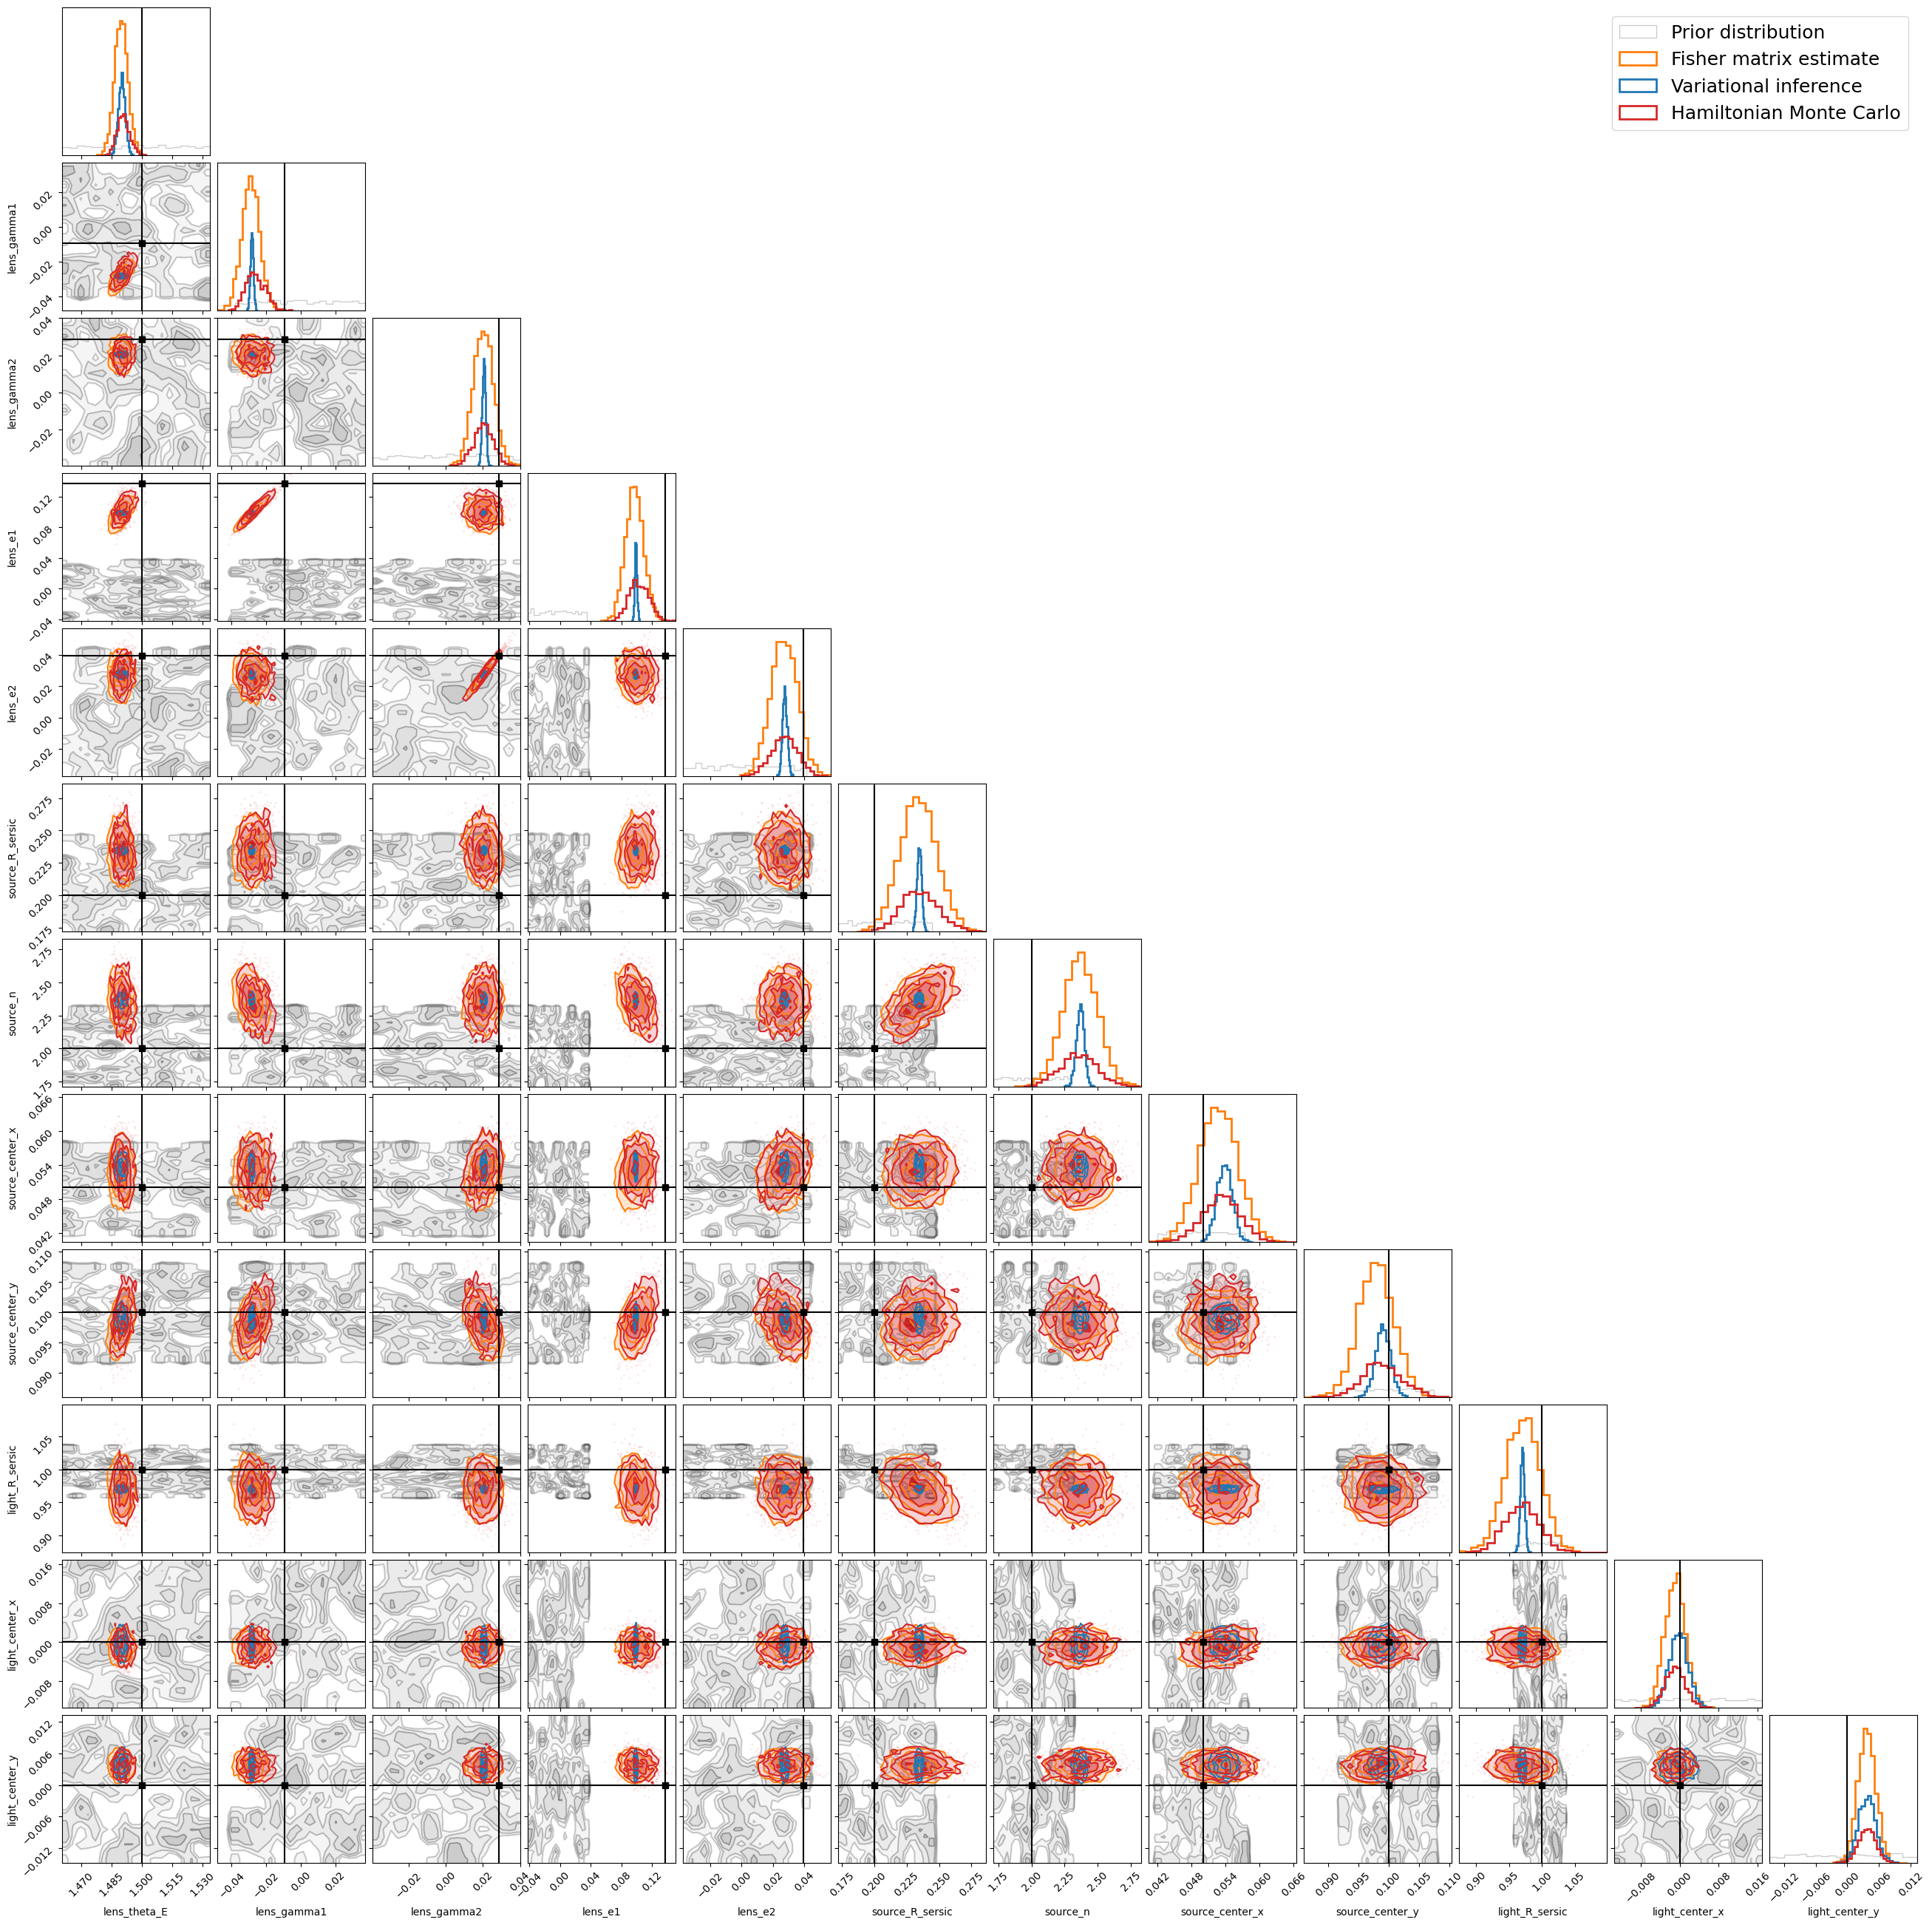

In [37]:
# format labels and markers for getdist
var_names_and_ranges = {
    'lens_theta_E': 0.3, 'lens_gamma1': 0.3, 'lens_gamma2': 0.3, 'lens_e1': 0.3, 'lens_e2':0.3, 
    'source_R_sersic': 0.3, 'source_n': 0.3, 'source_center_x': 0.3, 'source_center_y': 0.3,
    'light_R_sersic': 0.3, 'light_center_x': 0.3, 'light_center_y': 0.3,
}
var_names = list(var_names_and_ranges.keys())
ranges = list(var_names_and_ranges.values())

fig = None
fig = corner.corner(prior_samples, 
                    color='#00000033', 
                    var_names=var_names,
                    range=ranges, 
                    smooth=0.8,
                    fill_contours=True,
                    plot_datapoints=False,
                    hist_kwargs=dict(label="Prior distribution", linewidth=1),
                    fig=fig)
fig = corner.corner(fim_samples, 
                    color='tab:orange', 
                    var_names=var_names,
                    fill_contours=True,
                    plot_datapoints=False,
                    hist_kwargs=dict(label="Fisher matrix estimate", linewidth=2),
                    fig=fig)
fig = corner.corner(svi_samples, 
                    color='tab:blue', 
                    var_names=var_names,
                    fill_contours=True,
                    plot_datapoints=False,
                    hist_kwargs=dict(label="Variational inference", linewidth=2),
                    fig=fig)
fig = corner.corner(hmc_samples, 
                    color='tab:red', 
                    var_names=var_names,
                    fill_contours=True,
                    truths=input_params, truth_color='black', 
                    hist_kwargs=dict(label="Hamiltonian Monte Carlo", linewidth=2),
                    fig=fig)
axes = np.array(fig.get_axes()).reshape(len(var_names), len(var_names))
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, len(var_names)-1].legend(handles, labels, fontsize=18)
plt.show()